# Pytorch implemenation of an MNIST digit recongizer

* Goal is to train 99%+ accuracy hand written digit recongizer.
* Will also experiment with a few different kind of activiation functions.

https://github.com/pytorch/examples/tree/master/mnist
    

# 1. Basic MNIST test

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# parameters
USE_CUDA = False
BATCH_SIZE = 64

In [12]:
# our LeNet like model
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.conv3 = nn.Conv2d(64,128,3)
        self.conv1x1 = nn.Conv2d(128,10,1)
    
    def forward(self, x):
        """ Run input through network. """
        
        # layer 1        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        
        # layer 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        
        # layer 3
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        
        # this is a pseudo final layer with 1x1 convs and and average pool
        x = self.conv1x1(x)
        batch_size, label_count, final_width, final_height =  x.size()
        # why doesn't this work??
        #x = F.avg_pool2d((final_width, final_height))
        
        # map from [N,L,1,1] to [N,L]
        x = x.view(batch_size, label_count)
        
        return F.log_softmax(x, dim=1)      

# the training loop
def train(model, device, train_loader, optimizer, epoch, verbose=True):
    model.train()
    for i, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if verbose and i % 250 == 0:
            print("Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}".format(
                epoch, 100 * i / len(train_loader), loss.item()))
            
def test(model, device, test_loader, dataset_name="Test", max_samples=None, verbose=True):
    
    model.eval()
    test_loss = 0
    correct = 0        
    samples = 0    
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            samples += len(data)
            if max_samples is not None and samples > max_samples:
                break

    test_loss /= samples

    if verbose:
        print('{} set:\t Average loss: {:.4f},\t Accuracy: {:.1f}%'.format(
            dataset_name, test_loss, 100 * correct / samples))
    
    return correct / samples

In [13]:
# transform PIL images into normalized tensors.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# get the MNIST dataset
MNIST_train = datasets.MNIST("../data", train=True, download=True, transform=transform,)
MNIST_test = datasets.MNIST("../data", train=False, download=True, transform=transform,)
print("Found {} trianing examples and {} test examples.".format(len(MNIST_train), len(MNIST_test)))

Found 60000 trianing examples and 10000 test examples.


In [5]:
# setup for training

# pytorch doesn't seem to use more than 1 core on this problem, maybe the batch size isn't large enough,
# or perhaps it needs to be compiled from source to link in the MKL libraries
torch.set_num_threads(4)

device = torch.device("cuda" if USE_CUDA else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}

model = Net().to(device)

train_loader = torch.utils.data.DataLoader(
    MNIST_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True,    
    **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST_test, 
    batch_size=BATCH_SIZE,
    shuffle=True,     
    **kwargs)

optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1,10+1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, train_loader,"Train", max_samples = 1000)
    test(model, device, test_loader,"Test", max_samples = 1000)     

Train Epoch: 1 [0%]	Loss: 2.324535
Train Epoch: 1 [27%]	Loss: 0.242588
Train Epoch: 1 [53%]	Loss: 0.065106
Train Epoch: 1 [80%]	Loss: 0.033381
Train set:	 Average loss: 0.0333,	 Accuracy: 98.9%
Test set:	 Average loss: 0.0660,	 Accuracy: 98.3%
Train Epoch: 2 [0%]	Loss: 0.100185
Train Epoch: 2 [27%]	Loss: 0.093612
Train Epoch: 2 [53%]	Loss: 0.060415
Train Epoch: 2 [80%]	Loss: 0.019831
Train set:	 Average loss: 0.0271,	 Accuracy: 99.1%
Test set:	 Average loss: 0.0302,	 Accuracy: 98.9%
Train Epoch: 3 [0%]	Loss: 0.180798
Train Epoch: 3 [27%]	Loss: 0.178943
Train Epoch: 3 [53%]	Loss: 0.097092
Train Epoch: 3 [80%]	Loss: 0.021255
Train set:	 Average loss: 0.0299,	 Accuracy: 99.2%
Test set:	 Average loss: 0.0468,	 Accuracy: 98.4%
Train Epoch: 4 [0%]	Loss: 0.035581
Train Epoch: 4 [27%]	Loss: 0.001744
Train Epoch: 4 [53%]	Loss: 0.094340
Train Epoch: 4 [80%]	Loss: 0.016080
Train set:	 Average loss: 0.0184,	 Accuracy: 99.6%
Test set:	 Average loss: 0.0639,	 Accuracy: 98.5%
Train Epoch: 5 [0%]	Loss

In [8]:
print("Final test:")
test(model, device, train_loader,"Train", max_samples = 10000)
test(model, device, test_loader,"Test")     

Final test:
Train set:	 Average loss: 0.0110,	 Accuracy: 99.6%
Test set:	 Average loss: 0.0573,	 Accuracy: 98.7%


# 2. Experimentation on different activation functions


In [48]:
# our LeNet like model
class Net_Custom(nn.Module):
    
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.conv3 = nn.Conv2d(64,128,3)
        self.conv1x1 = nn.Conv2d(128,10,1)
        self.activation = activation
        
    def forward(self, x):
        """ Run input through network. """
        
        # layer 1        
        x = self.activation(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        
        # layer 2
        x = self.activation(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        
        # layer 3
        x = self.activation(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        
        # this is a pseudo final layer with 1x1 convs and and average pool
        x = self.conv1x1(x)
        batch_size, label_count, final_width, final_height =  x.size()
        
        # map from [N,L,1,1] to [N,L]
        x = x.view(batch_size, label_count)
        
        return F.log_softmax(x, dim=1)      


def run_experiment(name, activation_function, epochs = 10):  
        
    if name in results:
        print("Experiment {} skipped as already done.".format(name))
        return
        
    print("Running experiment {}".format(name))
            
    model = Net_Custom(activation_function).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scores = []

    for epoch in range(1,epochs+1):
        train(model, device, train_loader, optimizer, epoch, verbose=False)        
        scores.append((epoch,test(model, device, test_loader, "Test", verbose=False)))
            
    results[name] = scores
    models[name] = model

In [99]:
# reset results
results = {}
models = {}

In [ ]:
run_experiment("ReLu", F.relu)
run_experiment("Sigmoid", torch.sigmoid)
run_experiment("Tanh", torch.tanh)
run_experiment("Leaky ReLu", F.leaky_relu)
run_experiment("Abs", lambda x: F.relu(1 - torch.abs(1-x)))

Running experiment ReLu
Running experiment Sigmoid
Running experiment Tanh


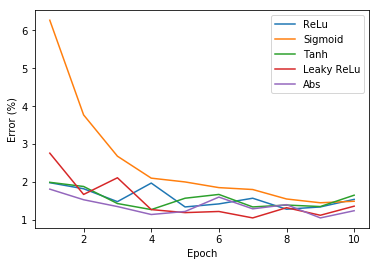

In [56]:
# plot the results
for function_name,scores in results.items():
    x = [x for (x,y) in scores]
    y = [100*(1-y) for (x,y) in scores]
    plt.plot(x,y,label=function_name)
    
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error (%)")
    
plt.show()


| Activation | Error   |
| -----------| --------|
| ReLu       | ?       |
| Sigmoid    | ?       |
| TanH       | ?       |
| ...        | ?       |


torch.Size([1, 28, 28])
[tensor([0.6900, 0.0000, 0.0200, 0.0000, 0.0400, 0.0000, 0.0000, 0.0200, 0.2200,
        0.0000])]
[tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])]


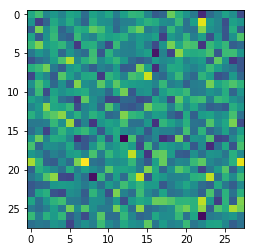

In [98]:
# check how model handles random input.
def pred(model, data):

    data = data.to(device)

    model.eval()
    
    with torch.no_grad():
        pred = model(data)                

    print([torch.round(x*100)/100 for x in torch.exp(pred)])

    
# The number 7 but with adjusted brightness
data, target = MNIST_test[0]
print(data.shape)
plt.imshow(np.asarray(data)[0,:,:])
data = torch.reshape(data, (1,1, 28,28))
data += 10
pred(model, data)

# gausian noise
data = torch.tensor(np.random.randn(1,1,28,28), dtype=torch.float32)
plt.imshow(np.asarray(data)[0,0,:,:])
data *= 7
pred(model, data)


            